# An Introduction to Dask
Date: 2023-02-13  
Author: Jason Beach  
Categories: Introduction_Tutorial, Data_Science  
Tags: pandas, python, dask  
<!--eofm-->

Let's take a quick tour of Python's Dask to see how this module may be able to help us with datasets too large for memory.

## Config

The power of Dask is that it is all Python under the hood.  The partitions that Dask works on are Pandas DataFrames.  In an environment where you don't have the JVM, so Apache Spark is not available, then Dask is a lightweight alternative.

As always, ensure you know your environment (memory, cores, threads) before attempting to work with performance-oriented code.


```bash
conda install dask
```

### Installations

The following are necessary because of version breakages with module `dask` ([issue](https://github.com/jupyter-server/jupyter_server/issues/1198)) and jupyter extension `dask-labextension`.  This may change in future versions.

### Prepare environment

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd

import dask
import dask.dataframe as dd

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
! python --version

Python 3.10.9


In [4]:
dask.__version__

'2023.2.0'

__Container__

If you're running locally, in a docker container, review the settings.  The following is a typical display.

<img src='./images/docker_settings_medium.png' width=400>

__Client__

In order to use the client, open the client display of the scheduler on `http://localhost:8787/`

If the jupyter lab dask-extension is available, then click on the extension icon, and copy-paste the Dashboard url into the seach bar.  Choose any displays (gold rows) that appear.  

Typical panes that should be opened include:

* Graph
* Cluster Memory
* Task Stream

__Machine__

`CPU(s): 6` is the number of logical cores, which equals “Thread(s) per core” × “Core(s) per socket” × “Socket(s)”. One socket is one physical CPU package (which occupies one socket on the motherboard); each socket hosts a number of physical cores, and each core can run one or more threads. 

In [6]:
! lscpu | head -n13

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          6
On-line CPU(s) list:             0-5
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i7-4870HQ CPU @ 2.50GHz
CPU family:                      6
Model:                           70
Thread(s) per core:              1
Core(s) per socket:              6
Socket(s):                       1


We have about 5GB of memory free.

In [11]:
! free -h

               total        used        free      shared  buff/cache   available
Mem:            11Gi       1.4Gi       993Mi       327Mi       9.3Gi       9.7Gi
Swap:          2.5Gi       8.0Mi       2.5Gi


Here, we have 1 socket containing a Intel(R) Core(TM) i7-4870HQ CPU, with only one thread per core.  Total memory is 11.7 GiB.

This matches with what we see in the Docker settings (above) and the LocalCluster display (below).

For now, we will use the automated optimizations, which includes 3 workers, here.

In [5]:
from dask.distributed import Client
c = Client()
c.cluster

LocalCluster(eb2f0892, 'tcp://127.0.0.1:41041', workers=3, threads=6, memory=11.70 GiB)

### Test configuration

Review the client panes while running the following cells to ensure everything is working properly.

In [8]:
import dask.array as da

x = da.random.random((10000,10000), chunks='16 MiB')
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1448, 1448), chunktype=numpy.ndarray>

In [10]:
y = (x * x.T) - x.mean(axis=0)
y.sum().compute()

-24999535.2237297

We can now feel confident that are environment is setup, correctly, and that we understand how resources are used.

### Clean-up

If you are done with the cluster, but still running processes, it is best to close the connections.

## Collections

The Dask ecosystem has a few different collections available.  We will stick to the usual DataFrame, at the moment, to keep things simple.

`Collections => TaskGraph => Schedulers (single, distributed)`

* (data) Arrays, DataFrame, Bag
* (functions) Delayed, Futures

## DataFrame

Dask DataFrame coordinate many pandas DataFrames / Series arranged along the index.  A Dask DataFrame is partitioned row-wise, grouping rows by index value for efficiency.  These pandas objects may live on disk or other machines.

If you need functions that are not implemented in Dask DataFrame, then you might want to look at dask.delayed which offers more flexibility.

### Basic functionality

The primary question when reading data is how will the new dataset be organized.  Dask can do this automatically, you can set the number of partitions (`from_pandas()`), or you can set the size of each partition (blocksize with `read_*()`).

* without enough partitions, you may not be able to use all of your cores effectively (ie. your dask.dataframe has only one partition then only one core can operate at a time)
* with too many partitions the scheduler may incur a lot of overhead deciding where to compute each task.

Generally you want a few times more partitions than you have cores. Every task takes up a few hundred microseconds in the scheduler.

Here, we ingest data from a Pandas DataFrame.  This allows us to repartition with the `npartitions` argument.  These are the basic functionality when used with an in-memory Pandas dataset.  Here, we've directed there to be 10 partitions of the data.  We can view how the data is separated by the divisions of the index, using Timestamps from a `pd.date_range`, here.

In [6]:
index = pd.date_range("1900-01-01", periods=2400000, freq="1H")
df = pd.DataFrame({"a": np.arange(2400000),
                   "b": list("abcaddbe" * 300000)
                  },
                   index=index
                   )
ddf = dd.from_pandas(df, npartitions=10)

In [7]:
len(ddf)

2400000

In [9]:
#index values for each partition
ddf.divisions

(Timestamp('1900-01-01 00:00:00', freq='H'),
 Timestamp('1927-05-20 00:00:00', freq='H'),
 Timestamp('1954-10-05 00:00:00', freq='H'),
 Timestamp('1982-02-20 00:00:00', freq='H'),
 Timestamp('2009-07-08 00:00:00', freq='H'),
 Timestamp('2036-11-23 00:00:00', freq='H'),
 Timestamp('2064-04-10 00:00:00', freq='H'),
 Timestamp('2091-08-27 00:00:00', freq='H'),
 Timestamp('2119-01-13 00:00:00', freq='H'),
 Timestamp('2146-05-31 00:00:00', freq='H'),
 Timestamp('2173-10-15 23:00:00', freq='H'))

In [10]:
ddf.npartitions

10

You can select each of the partitions, as well, which corresponds with the Timestamp divisions.

In [71]:
#select a partition
ddf.partitions[9]

,a,b
npartitions=1,,
2021-11-30 00:00:00,int64,object
2021-12-09 23:00:00,...,...


We describe the quardratic nature of compute efficiency by trying a few repartitions.  While increasing the partitions to 5, then 10, decreases the time to process the data, further increases to the number of partitions leads to an increase in processing time.

In [172]:
import time

partition_number = [1, 5, 10, 20, 40, 80] 
for partition in partition_number:
    tm_start = time.time()
    df = ddf.repartition(npartitions= partition)
    a1=df['a'].describe().compute()
    tm_end = time.time()
    print(f'With {partition} partitions, the time to complete processing is:\t{round(tm_end - tm_start, 3)} sec')

With 1 partitions, the time to complete processing is:	0.113 sec
With 5 partitions, the time to complete processing is:	0.093 sec
With 10 partitions, the time to complete processing is:	0.081 sec
With 20 partitions, the time to complete processing is:	0.178 sec
With 40 partitions, the time to complete processing is:	0.306 sec
With 80 partitions, the time to complete processing is:	0.542 sec


Partitions are also important because each will be save to an individual file when the DataFrame is saved.  If files are too large, they may pose a problem in copying to other systems.

In [122]:
empty_path = Path('./large_dataset/tmp')
empty_path.mkdir()

In [123]:
ddf.to_parquet(empty_path)

In [125]:
! du -h ./large_dataset/tmp/*

8.0K	./large_dataset/tmp/part.0.parquet
8.0K	./large_dataset/tmp/part.1.parquet
8.0K	./large_dataset/tmp/part.2.parquet
8.0K	./large_dataset/tmp/part.3.parquet
8.0K	./large_dataset/tmp/part.4.parquet
8.0K	./large_dataset/tmp/part.5.parquet
8.0K	./large_dataset/tmp/part.6.parquet
8.0K	./large_dataset/tmp/part.7.parquet
8.0K	./large_dataset/tmp/part.8.parquet
8.0K	./large_dataset/tmp/part.9.parquet


In [134]:
[child.unlink() for child in empty_path.iterdir() if child.is_file==True]
empty_path.rmdir()

[]

### Example data

We will use the [NYC TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), January 2022 files, as example data.  The example file format is Apache Parquet, which is an open-source column-based data as opposed to record-based, such as CSV or other text file formats.  This means values of each table column are stored next to each other, rather than those of each record.  Each file also maintains its own metadata, so that it can be used in a decoupled manner.

Some parquet datasets include a _metadata file which aggregates per-file metadata into a single location. For small-to-medium sized datasets this may be useful because it makes accessing the row-group metadata possible without reading parts of every file in the dataset. 

However, for large datasets the _metadata file can be problematic because it may be too large for a single endpoint to parse! If this is true, you can disable loading the _metadata file by specifying `ignore_metadata_file=True`.

Additional strengths of parquet file format are:

* don’t require schema inference / manual schema specification
* easier to compress
* columnar nature of Parquet files allows for column pruning, which often yields big query performance gains
* row group metadata in Parquet files allows for predicate pushdown filtering
* files are immutable

The January data is not too large to fit into memory, totaling 446.2 MB.  

In [86]:
! du -h large_dataset/nyc_tlc_record_data-jan/*

358M	large_dataset/nyc_tlc_record_data-jan/fhvhv_tripdata_2022-01.parquet
12M	large_dataset/nyc_tlc_record_data-jan/fhv_tripdata_2022-01.parquet
1.2M	large_dataset/nyc_tlc_record_data-jan/green_tripdata_2022-01.parquet
37M	large_dataset/nyc_tlc_record_data-jan/yellow_tripdata_2022-01.parquet


But the 2.6 GB of the first six months of High Volume For-Hire Vehicle Trip Records may be more difficult.

In [100]:
! du -h large_dataset/nyc_tlc_record_data-fhvhv/fhvhv_*

358M	large_dataset/nyc_tlc_record_data-fhvhv/fhvhv_tripdata_2022-01.parquet
389M	large_dataset/nyc_tlc_record_data-fhvhv/fhvhv_tripdata_2022-02.parquet
450M	large_dataset/nyc_tlc_record_data-fhvhv/fhvhv_tripdata_2022-03.parquet
435M	large_dataset/nyc_tlc_record_data-fhvhv/fhvhv_tripdata_2022-04.parquet
447M	large_dataset/nyc_tlc_record_data-fhvhv/fhvhv_tripdata_2022-05.parquet
437M	large_dataset/nyc_tlc_record_data-fhvhv/fhvhv_tripdata_2022-06.parquet


We also have complaints data

In [102]:
! du -h large_dataset/complaints/*

1.7M	large_dataset/complaints/complaints_complete_test.txt
256K	large_dataset/complaints/complaints_results_pct25.csv
844K	large_dataset/complaints/complaints_results_pct75.csv
2.0M	large_dataset/complaints/complaints_test.txt
2.0M	large_dataset/complaints/complaints_train.txt


### Reading data

When reading data from storage, we use the `blocksize` argument to change the size of each block, which affects the number of partitions.

If you don’t supply a value to the blocksize keyword, it is set to “default” and the blocksize is computed based on the available memory and number of cores on the machine, up to a max blocksize of 64 MB.

Changing the blocksize parameter will change the number of partitions (each pd.DataFrame).  Typically, it is best to keep partitions under 100MB in size.  This will allow memory for multiple core, as well as the coordinating processes.

In [11]:
path = '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/complaints/'
largefile = 'complaints_complete_test.txt'
largefile_path = Path(path) / largefile
largefile_path.is_file()

True

In [8]:
sizes = [None, "10KB", "25KB", "50KB", "100KB", 25e6]     #'25e6' refers to 25MB chunks
for size in sizes:
    ddf = dd.read_csv(largefile_path, blocksize=size)
    print(f'For blocksize: {size} \t the number of partitions is: \t{ddf.npartitions}')

For blocksize: None 	 the number of partitions is: 	1
For blocksize: 10KB 	 the number of partitions is: 	174
For blocksize: 25KB 	 the number of partitions is: 	69
For blocksize: 50KB 	 the number of partitions is: 	34
For blocksize: 100KB 	 the number of partitions is: 	17
For blocksize: 25000000.0 	 the number of partitions is: 	1


Dask can read all files within a directory.  Some of those files may be of different sizes.  Here, we use `split_row_groups=True` to partition data by row, instead of file.  However, this approach does not scale as well as using `split_row_groups=False` with a global metadata file because the footer will need to be loaded from every file in the dataset.

Limiting reading to specific columns can be selected, also.

In [8]:
path = '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/nyc_tlc_record_data-fhvhv/'
#largefile = 'fhvhv_tripdata_2022-01.parquet'
largefile_path = Path(path) #/ largefile

In [9]:
ddf = dd.read_parquet(
    largefile_path,
    split_row_groups=True,
    columns = ['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
               'request_datetime', 'on_scene_datetime', 'pickup_datetime',
               'dropoff_datetime', 'PULocationID', 'DOLocationID'
              ]
)

Dask chose 6 partitiions for the data, which is the same number as files.  Let's see a few different attributes we can get on the DataFrame

In [10]:
ddf.npartitions

6

While there are 6 divisions, there is no common index.  Dask didn't find a common index according to which the data is divided.  Each partition (Pandas DF) has its individual index.  This can be verified by looking at the partition indices.

Beware, `.reset_index()` creates a monotonically ascending index in each Partition - probably not what we want!

In [15]:
ddf.divisions

(None, None, None, None, None, None, None)

In [16]:
ddf.partitions[0]

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
npartitions=1,,,,,,,,,
,object,object,object,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],int64,int64
,...,...,...,...,...,...,...,...,...


In [21]:
df1 = ddf.get_partition(0)

In [23]:
df1.index.min().compute()

0

In [24]:
df1.index.max().compute()

14751590

In [25]:
df2 = ddf.get_partition(1)

In [26]:
df2.index.min().compute()

0

In [27]:
df2.index.max().compute()

16019282

Use `.set_index()` to ensure a good index for performing future operations.  The efficiency of all operations will be based upon their reference to the index.

We can provide an index for Dask, if it doesn't create one for us.  Here, we will use the 'request_datetime' for the trip.

Check the divisions to ensure it worked.

In [11]:
ddf2 = ddf.set_index('request_datetime', sorted=True)

In [12]:
ddf2.divisions

(Timestamp('2021-12-31 22:55:05'),
 Timestamp('2022-01-31 23:14:00'),
 Timestamp('2022-02-28 23:43:07'),
 Timestamp('2022-03-31 22:44:34'),
 Timestamp('2022-04-30 23:17:39'),
 Timestamp('2022-05-31 16:17:22'),
 Timestamp('2022-07-01 00:10:00'))

TODO: this fails???

We can create an artificial index from a sequence of increasing numbers.  This will allow us to use the `.loc()` method.

Then, review divisions.

In [15]:
cumlens = ddf.map_partitions(len).compute().cumsum()

# since processing will be done on a partition-by-partition basis, save them
# individually
new_partitions = [ddf.partitions[0]]
for npart, partition in enumerate(ddf.partitions[1:].partitions):
    partition.index = partition.index + cumlens[npart]
    new_partitions.append(partition)

# this is our new ddf
ddf = dd.concat(new_partitions)

ddf3 = ddf.set_index(ddf.index, sorted=True)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/core.py:5061: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [16]:
ddf3.divisions

(None, None, None, None, None, None, None)

### Describing data

In [6]:
path = '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/nyc_tlc_record_data-fhvhv/'
largefile_path = Path(path)

In [7]:
ddf = dd.read_parquet(
    largefile_path,
    split_row_groups=True,
    index = 'trip_time'
)
ddf.npartitions

6

In [8]:
ddf_trip_max = ddf['trip_time'].max()

In [9]:
ddf.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

While we can't get the actual data (because we 'lazily' haven't loaded it), we do have metadata information, such as column names, data types, and number of partitions.

In [11]:
ddf

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
npartitions=6,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns],int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


The single graph layer (task graph) can be visualized with graphviz.  The circles represent the tasks or functions and the squares represent the outputs/ results.  the number of dask tasks will be a multiple of the number of partitions, unless we perform an aggregate computation, like max().  

This shows the single `read-parquet` task for each of the partitions.

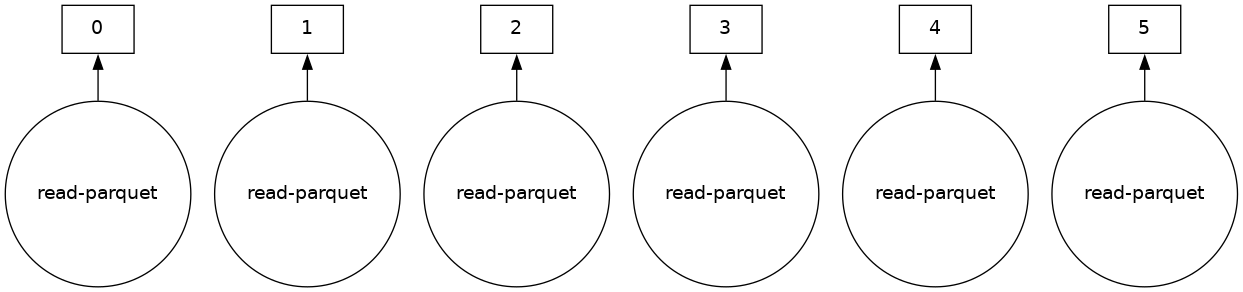

In [8]:
ddf.visualize()

The task graph for finding the maximum value of 'trip_time' is a little more interesting.  We see the `max()` is taken from each of the chunks (partitions), then the aggregate maximum is taken.

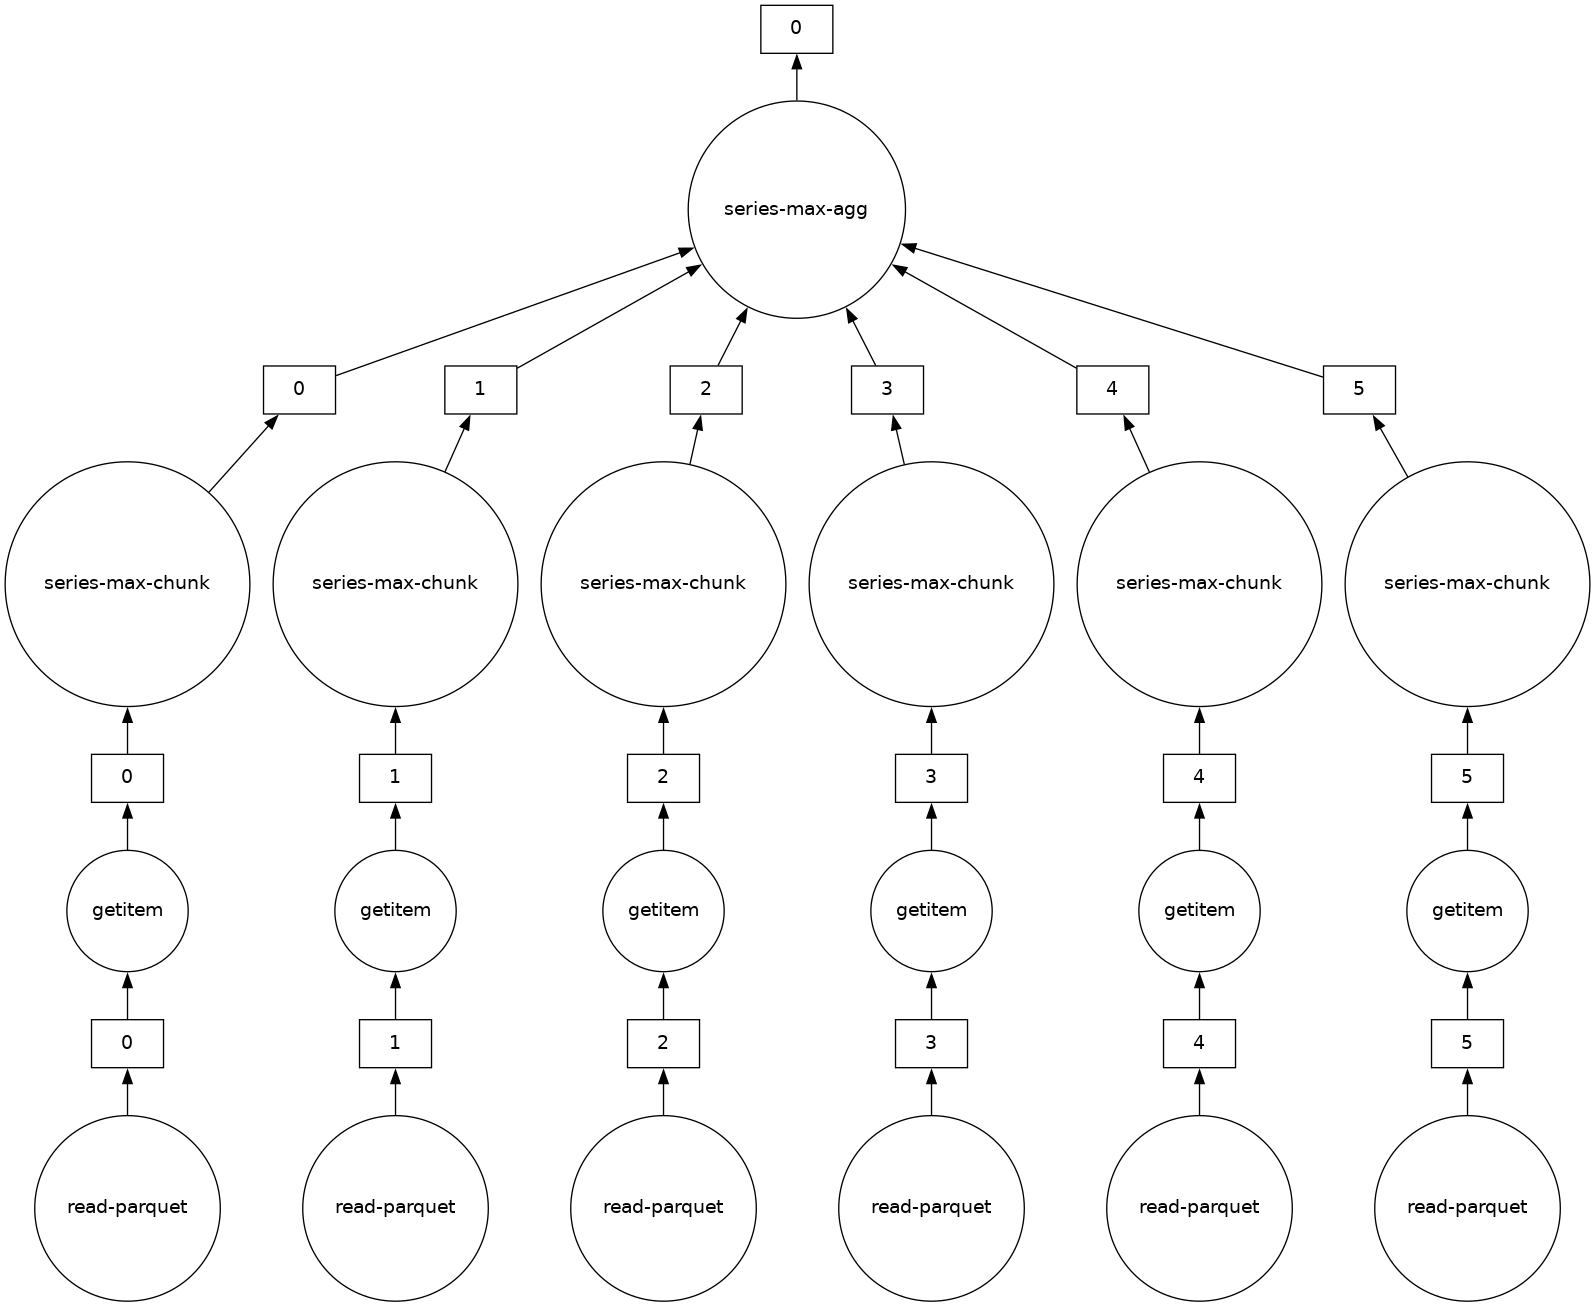

In [9]:
ddf_trip_max.visualize()

In [1]:
#TODO: this keeps running-out of memory!
#.00001 should be a small enough fraction!

Sampling records from the files can be a good first step in 

In [10]:
#ddf = ddf.repartition(npartitions=8)

In [ ]:
df = ddf.sample(frac=.000001)
#df = pd.DataFrame(df)
len(df)

The `.head()` method runs the compute and processes the first file, by default.  Below are the results.

In [10]:
ddf.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2022-01-01 00:05:31,2022-01-01 00:05:40,2022-01-01 00:07:24,2022-01-01 00:18:28,170,161,1.18,...,2.21,2.75,0.0,0.0,23.03,N,N,,N,N
1,HV0003,B03404,B03404,2022-01-01 00:19:27,2022-01-01 00:22:08,2022-01-01 00:22:32,2022-01-01 00:30:12,237,161,0.82,...,1.06,2.75,0.0,0.0,12.32,N,N,,N,N
2,HV0003,B03404,B03404,2022-01-01 00:43:53,2022-01-01 00:57:37,2022-01-01 00:57:37,2022-01-01 01:07:32,237,161,1.18,...,2.65,2.75,0.0,0.0,23.30,N,N,,N,N
3,HV0003,B03404,B03404,2022-01-01 00:15:36,2022-01-01 00:17:08,2022-01-01 00:18:02,2022-01-01 00:23:05,262,229,1.65,...,0.70,2.75,0.0,0.0,6.30,N,N,,N,N
4,HV0003,B03404,B03404,2022-01-01 00:25:45,2022-01-01 00:26:01,2022-01-01 00:28:01,2022-01-01 00:35:42,229,141,1.65,...,0.84,2.75,0.0,0.0,7.44,N,N,,N,N


__Descriptive statistics__



In [32]:
res = df[['request_datetime','on_scene_datetime']].describe()
res.compute()

/opt/conda/lib/python3.10/site-packages/dask/dataframe/core.py:3145: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  meta = data._meta_nonempty.describe(**datetime_is_numeric_kwarg)
/opt/conda/lib/python3.10/site-packages/dask/dataframe/core.py:3145: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  meta = data._meta_nonempty.describe(**datetime_is_numeric_kwarg)
/opt/conda/lib/python3.10/site-packages/dask/dataframe/core.py:3009: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `dat

,request_datetime,on_scene_datetime
unique,15151309,14748301
count,102914393,74821511
top,2022-05-19 07:30:00,2022-04-29 18:05:32
freq,312,26
first,2021-12-31 22:55:05,2021-12-31 23:28:59
last,2022-07-01 00:10:00,2022-06-30 23:59:59


In [187]:
ddf.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID'],
      dtype='object')

Getting the number of records is a little different from Pandas `df.shape`.  Here, `len(df)` is the most effecient method.

In [31]:
a = ddf.shape
a[0].compute(),a[1]

(1873, 2)

In [35]:
len(ddf)

1873

In [11]:
ddf.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
airport_fee                    float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
dtype: object

In [19]:
df['hvfhs_license_num'].value_counts().compute()

HV0003    74789774
HV0005    28124619
Name: hvfhs_license_num, dtype: int64

In [29]:
res = df.groupby('hvfhs_license_num')['trip_miles'].aggregate(['mean', 'std', 'max', 'min', 'sum'])
res.compute()

,mean,std,max,min,sum
hvfhs_license_num,,,,,
HV0003,4.973280,5.796234,628.700,0.0,3.719505e+08
HV0005,4.929644,5.558842,434.377,0.0,1.386444e+08


__TODO:User defined reductions__

Dask also supports user defined reductions.  To ensure proper performance, the reduction has to be formulated in terms of three independent steps (chunk, aggregate, finalize) and returns a single column.  The finalize step is optional.

In [28]:
custom_sum = dd.Aggregation('custom_sum',
               lambda s: s.sum(),
               lambda s0: s0.sum()
              )
res = df.groupby('hvfhs_license_num')['trip_miles'].agg(custom_sum)
res.compute()

hvfhs_license_num
HV0003    3.719505e+08
HV0005    1.386444e+08
Name: trip_miles, dtype: float64

These user functions are quite a bit more involved than is typical for Pandas.  A few examples can help this.

In [30]:
def chunk(grouped):
    """Chunks from each partition"""
    return grouped.max(), grouped.min()
def agg(chunk_maxes, chunk_mins):
    """Aggregate results from each partition"""
    return chunk_maxes.max(), chunk_mins.min()
def finalize(maxima, minima):
    """Final calculation from multiple results"""
    return maxima - minima

extent = dd.Aggregation('extent', chunk, agg, finalize=finalize)
res = df.groupby('hvfhs_license_num')['trip_miles'].agg(extent)
res.compute()

hvfhs_license_num
HV0003    628.700
HV0005    434.377
Name: trip_miles, dtype: float64

This example is applied to multiple columns.

In [31]:
nunique = dd.Aggregation(
    name="nunique",
    chunk=lambda s: s.apply(lambda x: list(set(x))),
    agg=lambda s0: s0.obj.groupby(level=list(range(s0.obj.index.nlevels))).sum(),
    finalize=lambda s1: s1.apply(lambda final: len(set(final))),
)

res = df.groupby('hvfhs_license_num').agg({'dispatching_base_num':nunique, 'originating_base_num':nunique})
res.compute()

,dispatching_base_num,originating_base_num
hvfhs_license_num,,
HV0003,28,36
HV0005,1,2


### Selections

Time to complete data queries is very much affected by the index.  Engine can not infer_divisions with unsorted index. 

In [6]:
path = '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/nyc_tlc_record_data-fhvhv/*.parquet'
largefile_path = Path(path)

In [7]:
ddf = dd.read_parquet(
    largefile_path,
    split_row_groups=True
)
ddf.npartitions

6

In [8]:
ddf.divisions
ddf.known_divisions

False

In [ ]:
#TODO: fail - no memory

In [ ]:
import time
tm_start = time.time()
ddf = ddf.set_index('request_datetime')
ddf = ddf.sort_values(by='request_datetime')
print(f'Process completed at: {time.time() - tm_start}')

In [ ]:
sorted_filepath = largefile_path / 'sorted'
ddf.to_parquet(sorted_filepath)

In [8]:
ddf = dd.read_parquet(
    largefile_path,
    split_row_groups=True,
    index = 'request_datetime',
    infer_divisions=True,
    sorted_index=False
)
ddf.npartitions

6

In [11]:
ddf.get_partition(0).head()

KeyboardInterrupt: 

In [ ]:
ddf.head(3)

Using the appropriate index can ensure optimal processing results.

In [9]:
res = ddf['2022-07-01 00:10:00':'2022-07-02 00:10:00']
len(res)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/methods.py:38: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return df.loc[iindexer]


KeyboardInterrupt: 

In [ ]:
res = df['request_datetime']['2022-07-01 00:10:00' : '2022-07-02 00:10:00'].compute()
len(res)